# simple_XRD_jl_new.pynb
### by Hezy Amiel

January-April 2023

Julia 1.8.5

In [2]:
using Plots, SpecialFunctions, Random, Distributions, DataFrames, CSV

## Functions

In [3]:
function Voigt_peak(θ::Vector, θ₀, A, w_L, w_G, n)
    """Returns a Voigt peak centered around θ₀, with amplitude A, width w, and mixing factor n """
    """untested"""
    γ = w_L / 2
    σ = w_G / (2√(2log(2)))
    z = @. -im * ((θ - θ₀) + im * γ) / (√2 * σ)
    return @. real(erfcx(z)) / (√(2pi) * σ)
end

Voigt_peak (generic function with 1 method)

In [4]:
function pseudo_Voigt_peak(θ::Vector, θ₀, A, w, n)
    """Returns a pseudo Voigt peak centered around θ₀, with amplitude A, width w, and mixing factor n """
    γ = w / 2
    σ = w / (2√(2log(2)))
    return @. A * (n * pdf.(Cauchy(θ₀, γ), θ) + (1-n) * pdf.(Normal(θ₀, σ), θ))
    # equivalent to:
    # return @. A * (n* (γ / pi) / ((θ - θ₀)^2 + γ^2) + (1 - n) * 1 / √(2π) / σ * exp(-(θ - θ₀)^2 / 2σ^2)
end

pseudo_Voigt_peak (generic function with 1 method)

In [5]:
function peaks_width(two_θ_deg, U, V, W)
    """Returns the width of a peak as afunction of 2θ with U, V, W parameters"""
    two_θ_rad = two_θ_deg * π / 180
    return @. √(U * tan(two_θ_rad / 2)^2 + V * tan(two_θ_rad / 2) + W)
end

peaks_width (generic function with 1 method)

In [6]:
function bragg_angels(wavelength, d_spacings)
    """ calculating the Bragg angles coresponding to each d-spacing"""
    sinθ = wavelength ./ (2 * d_spacings)
    sinθ_cleaned = [item for item in sinθ if abs(item) <= 1]  # removing values outside (-1,1)
    return 2 * (180 / π) * asin.(sinθ_cleaned)  # *2 for 2θ  
end

bragg_angels (generic function with 1 method)

In [7]:
function d_list(indices, a)
    """Returnes the inter-layers distances as a function of Miller_indices """
    return a ./ .√(sum(indices .^ 2, dims = 2))
end

d_list (generic function with 1 method)

In [8]:
function sum_peaks(θ::Vector, two_θ_list, U, V, W)
    """Sums peak functions to return intensity vs angle """
    y = zeros(size(θ))
    for item in two_θ_list
        y = y + pseudo_Voigt_peak(θ, item, 1, peaks_width(θ, U, V, W), 0.5)
    end
    return y
end

sum_peaks (generic function with 1 method)

In [9]:
function intensity_vs_angle(θ, indices, λ, a, U, V, W)
    """Building the XRD patterns """
    indices = (reduce(hcat, indices))'
    two_θ_list = bragg_angels(λ, d_list(indices, a))
    y = sum_peaks(θ, two_θ_list, U, V, W)
    return y
end

intensity_vs_angle (generic function with 1 method)

In [10]:
function Miller_indices(cell_type::String, min::Int64, max::Int64)
    """Returns a list of Miller indices for each one of the cubic symmetries"""
    if !(cell_type in ["SC", "BCC", "FCC"])
        error("Invalid cell_type: $cell_type. Expected 'SC', 'BCC', or 'FCC'.")
    end
    if min > max
        error("Minimum value cannot be greater than maximum value.")
    end
    if !(isa(min, Int) && isa(max, Int))
        error("Minimum and maximum values must be integers.")
    end
    
    if cell_type == "SC"
        # In simple cubic lattice, all Miller indices are allowed
        return [
            [h, k, l] for h = min:max for k = min:max for
            l = min:max if [h, k, l] != [0, 0, 0]
        ]
    elseif cell_type == "BCC"
        # In body centered cubic lattice, only indices with h+k+l=even are allowed
        return [
            [h, k, l] for h = min:max for k = min:max for
            l = min:max if iseven(h + k + l) && [h, k, l] != [0, 0, 0]
        ]
    elseif cell_type == "FCC"
        # In face centered cubic lattice, h,k,l must all be either odd or even
        return [
            [h, k, l] for h = min:max for k = min:max for l = min:max if
            ((iseven(h) && iseven(k) && iseven(l)) || (isodd(h) && isodd(k) && isodd(l))) &&
            [h, k, l] != [0, 0, 0]
        ]
    end
end


Miller_indices (generic function with 1 method)

In [11]:
function background(θ::Vector)
    """background function for the XRD pattern """
    return @. 2 + θ * (360 - θ) / 15000
end

background (generic function with 1 method)

In [12]:
function make_noisy(θ::Vector, y::Vector)
    """Adding some noise to the data """
    return (background(θ) + y) .* rand(Normal(1, 0.1), size(θ))
end

make_noisy (generic function with 1 method)

In [13]:
function read_file(filename)
    """Reading a text file with instrument data, and lattice parameters """
    instrument_data = Dict{AbstractString,Any}()
    lattice_params = Dict{AbstractString,Float64}()

    # read file line by line
    for line in eachline(filename)
        # split the line by whitespace and remove empty strings
        tokens = filter(x -> x ≠ "", split(line))

        if length(tokens) > 0 && tokens[1] ≠ "#"
            if tokens[1] in ["θ_min", "θ_max", "N"]
                instrument_data[tokens[1]] = parse(Int, tokens[2])
            elseif tokens[1] == "λ"
                instrument_data[tokens[1]] = parse(Float64, tokens[2])
            elseif tokens[1] in ["U", "V", "W"]
                instrument_data[tokens[1]] = parse(Float64, tokens[2])
            elseif tokens[1] in ["SC", "BCC", "FCC"]
                lattice_params[tokens[1]] = parse(Float64, tokens[3])
            end
        elseif length(tokens) > 1 && tokens[1] == "BCC" && tokens[2] ≠ "#"
            lattice_params[tokens[1]] = parse(Float64, tokens[3])
        elseif length(tokens) > 1 && tokens[1] == "FCC" && tokens[2] ≠ "#"
            lattice_params[tokens[1]] = parse(Float64, tokens[3])
        elseif length(tokens) > 1 && tokens[1] == "SC" && tokens[2] ≠ "#"
            lattice_params[tokens[1]] = parse(Float64, tokens[3])
        end
    end

    return instrument_data, lattice_params
end



read_file (generic function with 1 method)

In [14]:
function do_it_zero(file_name)
    """colecting input data, building the XRD pattern with background and noise, plotting it """
    instrument_data, lattice_params = read_file(file_name)

    θ = collect(LinRange(instrument_data["θ_min"], instrument_data["θ_max"], instrument_data["N"]))
    return θ
end

do_it_zero (generic function with 1 method)

In [46]:
function do_it(file_name, lattice_type)
    """colecting input data, building the XRD pattern with background and noise, plotting it """
    instrument_data, lattice_params = read_file(file_name)

    N = instrument_data["N"]
    θ = collect(LinRange(instrument_data["θ_min"], instrument_data["θ_max"], instrument_data["N"]))
    y = zeros(instrument_data["N"])
    λ = instrument_data["λ"]
    U, V, W = instrument_data["U"], instrument_data["V"], instrument_data["W"] 
    
    a = lattice_params[lattice_type]

    indices = Miller_indices(lattice_type, -5, 5)

    y = (background(θ) + 
        intensity_vs_angle(θ, indices, λ, a, U, V, W)) .*
        rand(Normal(1, 0.1), N)

    the_title = "XRD - " * lattice_type
  
    p = plot(θ, y, title=the_title, xlabel="2θ (deg)", ylabel="Intensity (arb.)")
    display(p)
    savefig(p, the_title)

    return θ, y
end

do_it (generic function with 1 method)

## Main

In [16]:
Random.seed!(347) # Setting the seed for random noise

TaskLocalRNG()

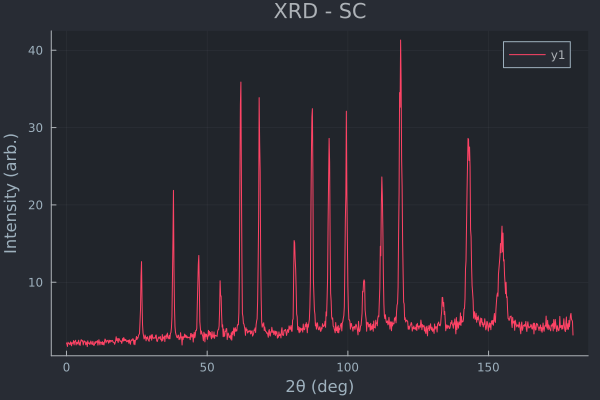

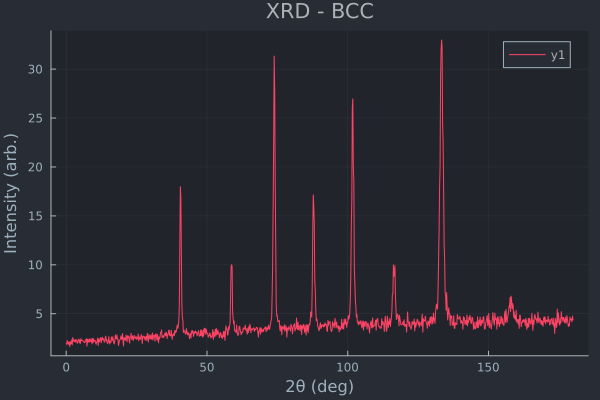

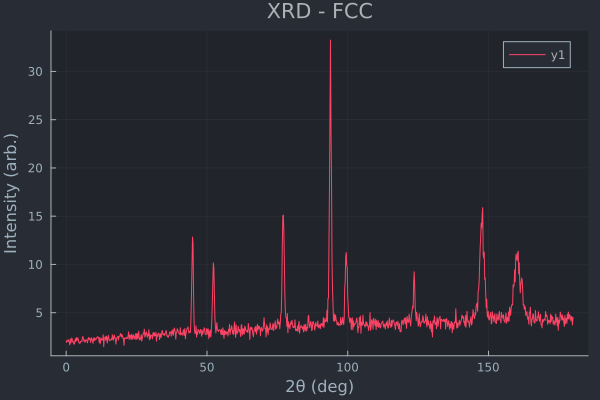

"XRD_results.csv"

In [47]:
θ = do_it_zero("simple_XRD.txt")
df = DataFrame(θ=θ, SC=θ, BCC=θ, FCC=θ)

for lattice_type in ("SC", "BCC", "FCC")
    θ , y = do_it("simple_XRD.txt", lattice_type)
    df[:, "θ"] = θ
    df[:, lattice_type] = y
end

CSV.write("XRD_results.csv", df)